In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('../src_jobs/')

In [2]:
import pickle
from itertools import repeat
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from artifact import Saw_weighted_uniform
from detector import WindowTransformerDetector

from data import ArtifactDataset, CachedArtifactDataset

/opt/miniconda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import matplotlib.pyplot as plt

artifact = Saw_weighted_uniform()

a = artifact.generate()
plt.plot(a)

ValueError: a and p must have same size

In [3]:
test_width = 1024
#  test_file = Path(f"../data/test{test_width}.pkl")
datasets = [
    #"australian_electricity_demand_dataset",
    #"electricity_hourly_dataset",
    #"electricity_load_diagrams",
    #"HouseholdPowerConsumption1",
    #"HouseholdPowerConsumption2",
    #"london_smart_meters_dataset_without_missing_values",
    #"solar_10_minutes_dataset",
    "wind_farms_minutely_dataset_without_missing_values",
]

In [4]:
def load_series(names: list[str], split: str):
    series = list()
    counts = list()
    for name in names:
        with open(f"../data/processed/{name}_{split}.pickle", "rb") as f:
            raw = [a for a in pickle.load(f) if len(a) > test_width]
            series.extend(np.array(a).astype(np.float32) for a in raw)
            counts.extend(repeat(1 / len(raw), len(raw)))
    counts = np.array(counts)
    return series, counts / counts.sum()

In [33]:
train_data, train_weights = load_series(datasets, "VAL")

In [34]:
data_df = pd.DataFrame(train_data)

In [36]:
data_df.loc[1].min()

-1.0335290431976318

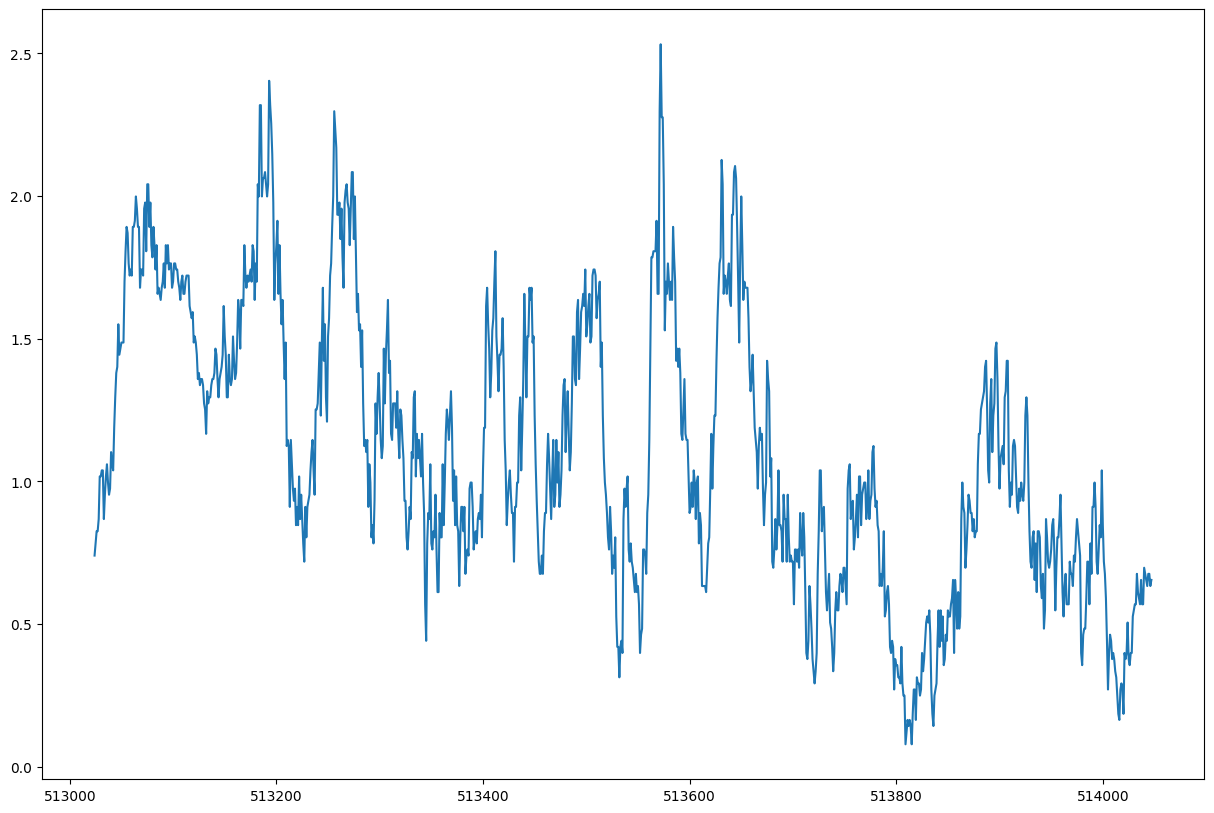

In [29]:
# number_windows = int(data_df.shape[1]/test_width)

# for i in range(number_windows):
#     plt.figure(figsize=(15, 10))
#     plt.plot(data_df.loc[1][i*test_width:i*test_width+test_width].plot(figsize=(15,10)), label="data")
#     plt.legend()
#     plt.show()
length = 1024
i = 501
plot = data_df.loc[1][i*length:i*length+length].plot(figsize=(15,10))



In [18]:
example = val[0]
stride  = 64
window  = detector.window
length  = len(example["data"])

# add artifact to data
example_data = torch.tensor(example["data"] + example["artifact"])

# store prediction for each window
predictions = torch.zeros(((length - window) // stride + 1, length))

# store number of times each mask was predicted

masks = torch.zeros(length)
for i, j in enumerate(range(0, length - window + 1, stride)):
    # slice out window
    s = example_data[j : j + window]
    # make prediction and insert into prediction
    predictions[i, j : j + window] = detector(s.unsqueeze(0))
    # update count
    masks[j : j + window] += 1

In [19]:
predictions = predictions.sum(axis=0) / masks


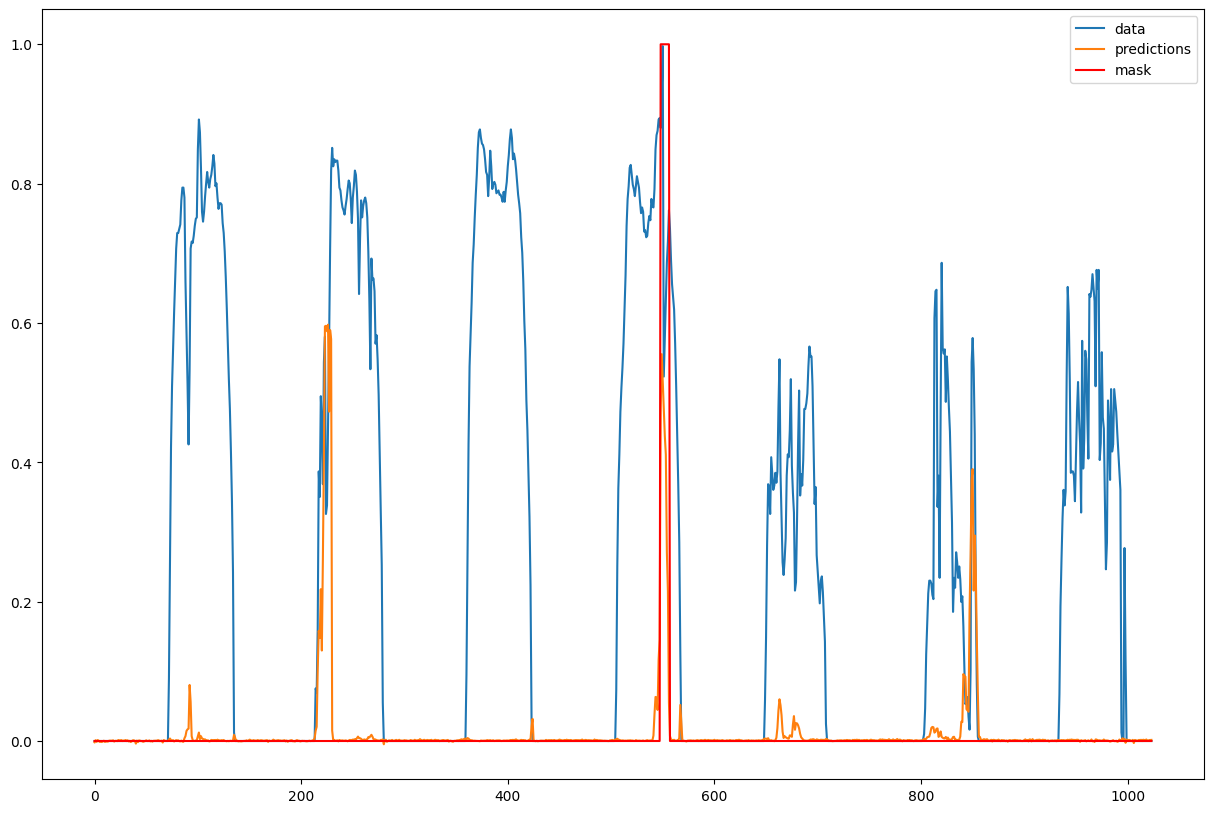

In [20]:
plt.figure(figsize=(15, 10))
plt.plot(example_data, label="data")
plt.plot(predictions, label="predictions")
plt.plot(example["mask"], c="red", label="mask")
plt.legend()
plt.show()